In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from time import time
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import string
import re
import seaborn as sns
!pip install fuzzywuzzy

import itertools
import datetime

from keras.utils import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/DHRUVA-N-L-CHOUDHARY/text_alignment_analysis/main/train.csv')
TRAIN_CSV = data
!gdown "1X82o1u-YEq6pjmxPCUiEjudMOae9k2R-&confirm=t"
EMBEDDING_FILE = './GoogleNews-vectors-negative300.bin.gz'
MODEL_SAVING_DIR = './Models/Kaggle/Quora/'

Downloading...
From: https://drive.google.com/uc?id=1X82o1u-YEq6pjmxPCUiEjudMOae9k2R-&confirm=t
To: /content/GoogleNews-vectors-negative300.bin.gz
100% 1.65G/1.65G [00:10<00:00, 164MB/s]


## Basic Data Exploration

In [4]:
print(data.shape)

(404290, 6)


In [8]:
data[:10000]['is_duplicate'].value_counts()

0    6289
1    3711
Name: is_duplicate, dtype: int64

In [9]:
data.head(100)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
...,...,...,...,...,...,...
95,95,191,192,How does 3D printing work?,How do 3D printing work?,1
96,96,193,194,What was it like to attend Caltech with Jeremy...,Who are some notable folks who attended Caltech?,0
97,97,195,196,Why did harry become a horcrux?,What is a Horcrux?,0
98,98,197,198,What are the best associate product manager (A...,What are the general requirement to become a P...,0


In [10]:
data = data[:10000]

In [11]:
data.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [12]:
data = data.dropna()

In [13]:
data.shape

(10000, 6)

In [14]:
data.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [15]:
data.describe()

,id,qid1,qid2,is_duplicate
count,10000.00000,10000.000000,10000.000000,10000.000000
mean,4999.50000,9612.395200,9602.829100,0.371100
std,2886.89568,5602.942387,5609.387868,0.483123
min,0.00000,1.000000,2.000000,0.000000
25%,2499.75000,4750.500000,4738.000000,0.000000
50%,4999.50000,9570.000000,9541.000000,0.000000
75%,7499.25000,14451.500000,14454.500000,1.000000
max,9999.00000,19412.000000,19413.000000,1.000000


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            10000 non-null  int64 
 1   qid1          10000 non-null  int64 
 2   qid2          10000 non-null  int64 
 3   question1     10000 non-null  object
 4   question2     10000 non-null  object
 5   is_duplicate  10000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 468.9+ KB


In [17]:
print(data.is_duplicate.value_counts())
print(data.is_duplicate.value_counts()/data.is_duplicate.value_counts().sum()*100)

0    6289
1    3711
Name: is_duplicate, dtype: int64
0    62.89
1    37.11
Name: is_duplicate, dtype: float64


duplicate question containing data point are 36.92% and non duplicate containing data point are 63.08%

In [18]:
qids = np.append(data.qid1.values , data.qid2.values)
qids.shape

(20000,)

In [19]:
print("total no of unique question in data set: ", len(set(qids)))

total no of unique question in data set:  19413


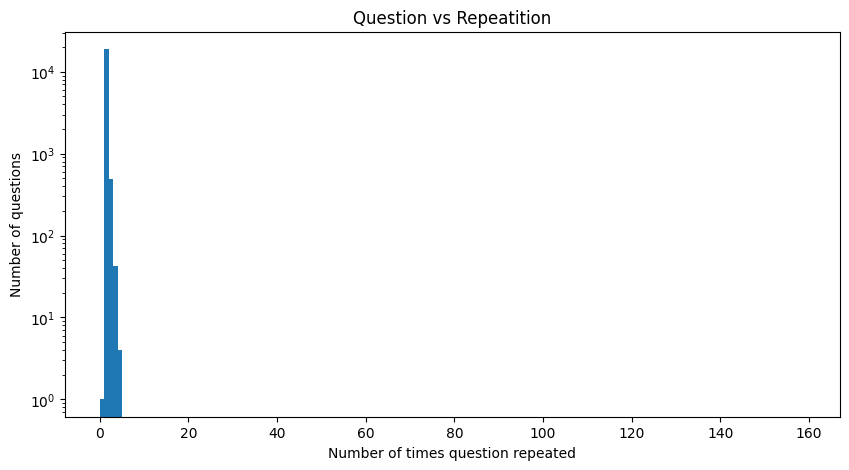

Minimun occurences of any question:  0
Maximum occurences of any question:  4


In [20]:
occurences = np.bincount(qids)
plt.figure(figsize=(10,5))
plt.hist(occurences, bins=range(0,160))
plt.yscale('log')
plt.xlabel('Number of times question repeated')
plt.ylabel('Number of questions')
plt.title('Question vs Repeatition')
plt.show()
print("Minimun occurences of any question: " , np.min(occurences))
print("Maximum occurences of any question: " , np.max(occurences))

## Data preprocessing

In [21]:
class tPreprocessing:

    def __init__(self , data):
        self.data = data
        self.my_stopword = list(stopwords.words('english'))
        self.my_lemmatizer = WordNetLemmatizer()

    def text_preprocessing(self , data , column_name):

        data_copy = data.copy()

        data_copy[column_name] = data_copy[column_name].apply(self.lower_text)
        data_copy[column_name] = data_copy[column_name].apply(self.remove_punctuation)
        data_copy[column_name] = data_copy[column_name].apply(self.replace_numeric_to_string)
        data_copy[column_name] = data_copy[column_name].apply(self.remove_urls)
        data_copy[column_name] = data_copy[column_name].apply(self.replace_special_character_to_string_equalent)
        data_copy[column_name] = data_copy[column_name].apply(self.decontrate_words)
        data_copy[column_name] = data_copy[column_name].apply(self.remove_stopwords)
        data_copy[column_name] = data_copy[column_name].apply(self.text_lemmatization)

        return data_copy


    def lower_text(self , text):
        return text.lower().strip()

    def remove_punctuation(self , text):
        text = text.translate(str.maketrans("", "", string.punctuation))
        return text

    def replace_numeric_to_string(self, text):
        text = text.replace(',000,000,000 ', 'b ')
        text = text.replace(',000,000 ', 'm ')
        text = text.replace(',000', 'k ')
        text = re.sub(r'([0-9]+)000000000' , r'\1b', text)
        text = re.sub(r'([0-9]+)000000' , r'\1m', text)
        text = re.sub(r'([0-9]+)000' , r'\1k', text)
        return text

    def remove_urls(self, text):
        text = re.sub(r"http\S+", "", text)
        return text

    def replace_special_character_to_string_equalent(self , text):
        text = text.replace('%' , ' percent')
        text = text.replace('$' , ' dollar')
        text = text.replace('₹' , ' repee')
        text = text.replace('€' , ' euro')
        text = text.replace('@' , ' at')
        return text

    def remove_stopwords(self , text):
        words = text.split()
        new_words = [word for word in words if not word in self.my_stopword]
        text = ' '.join(new_words)
        return text

    def text_lemmatization(self , text):
        text = ' '.join([self.my_lemmatizer.lemmatize(word) for word in text.split()])
        return text

    def decontrate_words(self , text):
        contractions = {
            "ain't": "am not",
            "aren't": "are not",
            "can't": "can not",
            "can't've": "can not have",
            "'cause": "because",
            "could've": "could have",
            "couldn't": "could not",
            "couldn't've": "could not have",
            "didn't": "did not",
            "doesn't": "does not",
            "don't": "do not",
            "hadn't": "had not",
            "hadn't've": "had not have",
            "hasn't": "has not",
            "haven't": "have not",
            "he'd": "he would",
            "he'd've": "he would have",
            "he'll": "he will",
            "he'll've": "he will have",
            "he's": "he is",
            "how'd": "how did",
            "how'd'y": "how do you",
            "how'll": "how will",
            "how's": "how is",
            "i'd": "i would",
            "i'd've": "i would have",
            "i'll": "i will",
            "i'll've": "i will have",
            "i'm": "i am",
            "i've": "i have",
            "isn't": "is not",
            "it'd": "it would",
            "it'd've": "it would have",
            "it'll": "it will",
            "it'll've": "it will have",
            "it's": "it is",
            "let's": "let us",
            "ma'am": "madam",
            "mayn't": "may not",
            "might've": "might have",
            "mightn't": "might not",
            "mightn't've": "might not have",
            "must've": "must have",
            "mustn't": "must not",
            "mustn't've": "must not have",
            "needn't": "need not",
            "needn't've": "need not have",
            "o'clock": "of the clock",
            "oughtn't": "ought not",
            "oughtn't've": "ought not have",
            "shan't": "shall not",
            "sha'n't": "shall not",
            "shan't've": "shall not have",
            "she'd": "she would",
            "she'd've": "she would have",
            "she'll": "she will",
            "she'll've": "she will have",
            "she's": "she is",
            "should've": "should have",
            "shouldn't": "should not",
            "shouldn't've": "should not have",
            "so've": "so have",
            "so's": "so as",
            "that'd": "that would",
            "that'd've": "that would have",
            "that's": "that is",
            "there'd": "there would",
            "there'd've": "there would have",
            "there's": "there is",
            "they'd": "they would",
            "they'd've": "they would have",
            "they'll": "they will",
            "they'll've": "they will have",
            "they're": "they are",
            "they've": "they have",
            "to've": "to have",
            "wasn't": "was not",
            "we'd": "we would",
            "we'd've": "we would have",
            "we'll": "we will",
            "we'll've": "we will have",
            "we're": "we are",
            "we've": "we have",
            "weren't": "were not",
            "what'll": "what will",
            "what'll've": "what will have",
            "what're": "what are",
            "what's": "what is",
            "what've": "what have",
            "when's": "when is",
            "when've": "when have",
            "where'd": "where did",
            "where's": "where is",
            "where've": "where have",
            "who'll": "who will",
            "who'll've": "who will have",
            "who's": "who is",
            "who've": "who have",
            "why's": "why is",
            "why've": "why have",
            "will've": "will have",
            "won't": "will not",
            "won't've": "will not have",
            "would've": "would have",
            "wouldn't": "would not",
            "wouldn't've": "would not have",
            "y'all": "you all",
            "y'all'd": "you all would",
            "y'all'd've": "you all would have",
            "y'all're": "you all are",
            "y'all've": "you all have",
            "you'd": "you would",
            "you'd've": "you would have",
            "you'll": "you will",
            "you'll've": "you will have",
            "you're": "you are",
            "you've": "you have"
           }

        text_decontrate = []

        for word in text.split():
            if word in contractions:
                word = contractions[word]
            text_decontrate.append(word)

        text = ' '.join(text_decontrate)

        return text


In [22]:
tp = tPreprocessing(data)
data_ = tp.text_preprocessing(data , 'question1')
data__ = tp.text_preprocessing(data_ , 'question2')

train_df = data__

In [23]:
data__.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,step step guide invest share market india,step step guide invest share market,0
1,1,3,4,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0
3,3,7,8,mentally lonely solve,find remainder math2324math divided 2423,0
4,4,9,10,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0


## Features Engineering

In [24]:
from fuzzywuzzy import fuzz

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [25]:
class FeatureEngineering:

    def __init__(self , data):
        self.data = data


    def feature_extraction(self , data):

        data_copy = data.copy()

        data_copy['length_of_q1'] = data_copy['question1'].apply(lambda text : len(text))

        data_copy['length_of_q2'] = data_copy['question2'].apply(lambda text : len(text))

        data_copy['total_number_of_words_in_q1'] = data_copy['question1'].apply(lambda text : len(nltk.word_tokenize(text)))

        data_copy['total_number_of_words_in_q2'] = data_copy['question2'].apply(lambda text : len(nltk.word_tokenize(text)))

        data_copy['sum_of_total_words_of_q1_and_q2'] = data_copy['total_number_of_words_in_q1'] + data_copy['total_number_of_words_in_q2']

        data_copy['number_of_unique_words_in_q1'] = data_copy['question1'].apply(lambda text : len(set(nltk.word_tokenize(text))))

        data_copy['number_of_unique_words_in_q2'] = data_copy['question2'].apply(lambda text : len(set(nltk.word_tokenize(text))))

        data_copy['sum_of_total_uinque_words_of_q1_and_q2'] = data_copy['number_of_unique_words_in_q1'] + data_copy['number_of_unique_words_in_q2']

        data_copy['ratio_of_total_unique_words_and_total_words'] = data_copy['sum_of_total_uinque_words_of_q1_and_q2']/data_copy['sum_of_total_words_of_q1_and_q2']

        data_copy['number_of_common_words_in_q1_and_q2'] = data_copy.apply(lambda x : len(set(x.question1.split()).intersection(set(x.question2.split()))) , axis=1)

        data_copy['ratio_of_common_words_of_q1q2_and_total_words'] = data_copy['number_of_common_words_in_q1_and_q2']/data_copy['sum_of_total_words_of_q1_and_q2']

        data_copy['ratio_of_common_words_of_q1q2_and_total_unique_words'] = data_copy['number_of_common_words_in_q1_and_q2']/data_copy['sum_of_total_uinque_words_of_q1_and_q2']

        data_copy['ratio_of_common_words_and_length_of_smaller_question'] = data_copy['number_of_common_words_in_q1_and_q2']/np.minimum(data_copy['length_of_q1'] , data_copy['length_of_q2'])

        data_copy['ratio_of_common_words_and_length_of_larger_question'] = data_copy['number_of_common_words_in_q1_and_q2']/np.maximum(data_copy['length_of_q1'] , data_copy['length_of_q2'])

        return data_copy

    def add_fuzzywuzzy_features(self , data):

        data_copy = data.copy()

        data_copy['fuzz_ratio'] = data_copy.apply(lambda x : fuzz.ratio(x.question1 , x.question2) , axis=1)

        data_copy['fuzz_partial_ratio'] = data_copy.apply(lambda x : fuzz.partial_ratio(x.question1 , x.question2) , axis=1)

        data_copy['fuzz_token_sort_ratio'] = data_copy.apply(lambda x : fuzz.token_sort_ratio(x.question1 , x.question2) , axis=1)

        data_copy['fuzz_token_set_ratio'] = data_copy.apply(lambda x : fuzz.token_set_ratio(x.question1 , x.question2) , axis=1)

        return data_copy


In [26]:
fe = FeatureEngineering(data__)
df = fe.feature_extraction(data__)
df = fe.add_fuzzywuzzy_features(df)

In [27]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,length_of_q1,length_of_q2,total_number_of_words_in_q1,total_number_of_words_in_q2,...,ratio_of_total_unique_words_and_total_words,number_of_common_words_in_q1_and_q2,ratio_of_common_words_of_q1q2_and_total_words,ratio_of_common_words_of_q1q2_and_total_unique_words,ratio_of_common_words_and_length_of_smaller_question,ratio_of_common_words_and_length_of_larger_question,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio
0,0,1,2,step step guide invest share market india,step step guide invest share market,0,41,35,7,6,...,0.846154,5,0.384615,0.454545,0.142857,0.121951,92,100,92,100
1,1,3,4,story kohinoor kohinoor diamond,would happen indian government stole kohinoor ...,0,31,67,4,9,...,0.846154,2,0.153846,0.181818,0.064516,0.029851,59,94,59,84
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0,44,36,6,5,...,1.000000,2,0.181818,0.181818,0.055556,0.045455,55,46,65,65
3,3,7,8,mentally lonely solve,find remainder math2324math divided 2423,0,21,40,3,5,...,1.000000,0,0.000000,0.000000,0.000000,0.000000,23,24,20,20
4,4,9,10,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0,60,29,10,5,...,1.000000,2,0.133333,0.133333,0.068966,0.033333,25,52,40,51


In [28]:
df.shape

(10000, 24)

In [29]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'length_of_q1', 'length_of_q2', 'total_number_of_words_in_q1',
       'total_number_of_words_in_q2', 'sum_of_total_words_of_q1_and_q2',
       'number_of_unique_words_in_q1', 'number_of_unique_words_in_q2',
       'sum_of_total_uinque_words_of_q1_and_q2',
       'ratio_of_total_unique_words_and_total_words',
       'number_of_common_words_in_q1_and_q2',
       'ratio_of_common_words_of_q1q2_and_total_words',
       'ratio_of_common_words_of_q1q2_and_total_unique_words',
       'ratio_of_common_words_and_length_of_smaller_question',
       'ratio_of_common_words_and_length_of_larger_question', 'fuzz_ratio',
       'fuzz_partial_ratio', 'fuzz_token_sort_ratio', 'fuzz_token_set_ratio'],
      dtype='object')

## Exploratery Data Analysis

<ipython-input-30-d2d085dc83db>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='length_of_q1' , hue='is_duplicate' , data=df , shade=True)


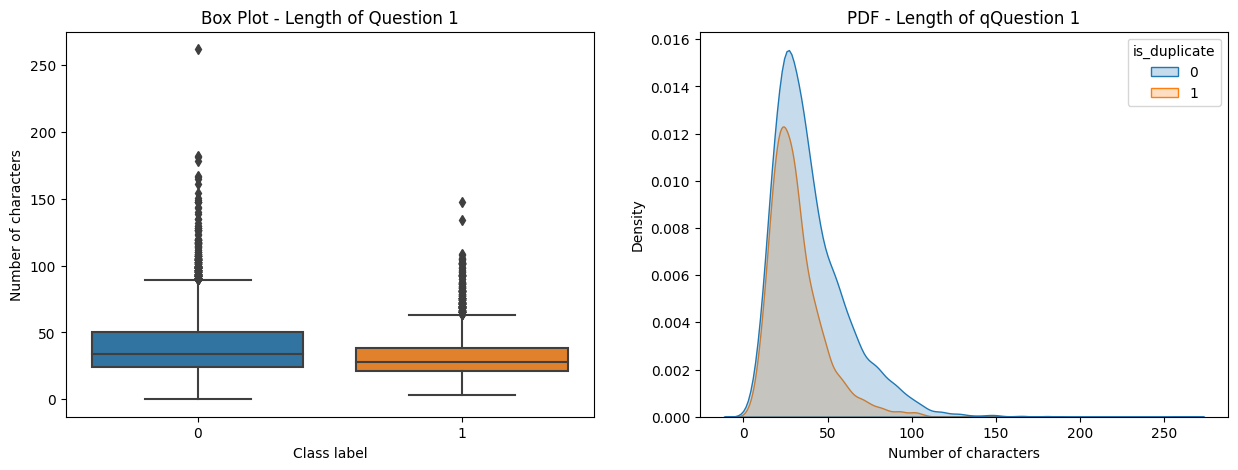

In [30]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='length_of_q1' , data=df)
plt.title('Box Plot - Length of Question 1')
plt.xlabel('Class label')
plt.ylabel('Number of characters')

plt.subplot(1,2,2)

sns.kdeplot(x='length_of_q1' , hue='is_duplicate' , data=df , shade=True)
plt.title('PDF - Length of qQuestion 1')
plt.xlabel('Number of characters')

plt.show()

<ipython-input-31-32467adb2037>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='length_of_q2' , hue='is_duplicate' , data=df , shade=True)


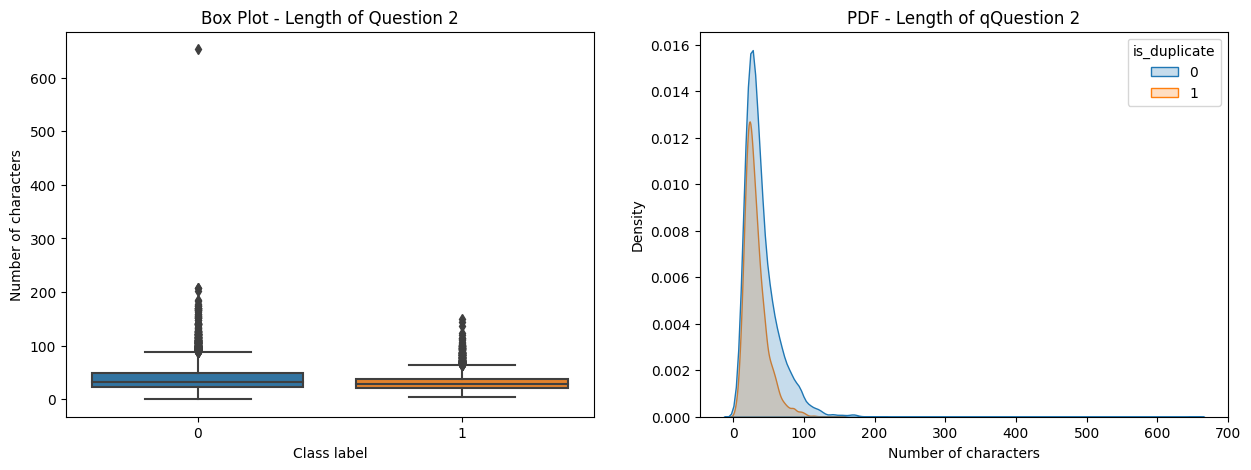

In [31]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='length_of_q2' , data=df)
plt.title('Box Plot - Length of Question 2')
plt.xlabel('Class label')
plt.ylabel('Number of characters')

plt.subplot(1,2,2)

sns.kdeplot(x='length_of_q2' , hue='is_duplicate' , data=df , shade=True)
plt.title('PDF - Length of qQuestion 2')
plt.xlabel('Number of characters')

plt.show()

<ipython-input-32-37f1834ade47>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='total_number_of_words_in_q1' , hue='is_duplicate' , data=df , shade=False)


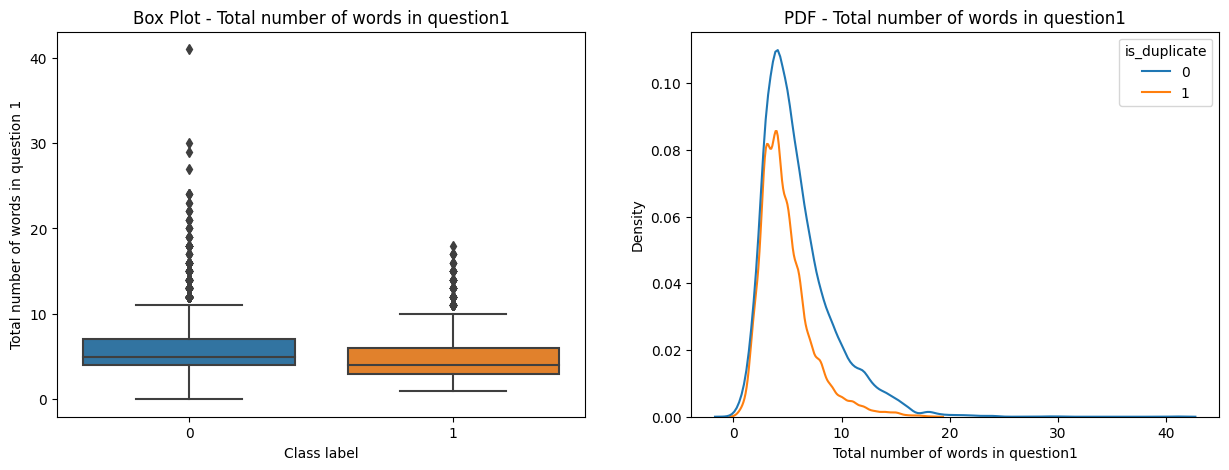

In [32]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='total_number_of_words_in_q1' , data=df)
plt.title('Box Plot - Total number of words in question1')
plt.xlabel('Class label')
plt.ylabel('Total number of words in question 1')

plt.subplot(1,2,2)

sns.kdeplot(x='total_number_of_words_in_q1' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Total number of words in question1')
plt.xlabel('Total number of words in question1')

plt.show()

<ipython-input-33-9ee5a7fb86b4>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='total_number_of_words_in_q2' , hue='is_duplicate' , data=df , shade=False)


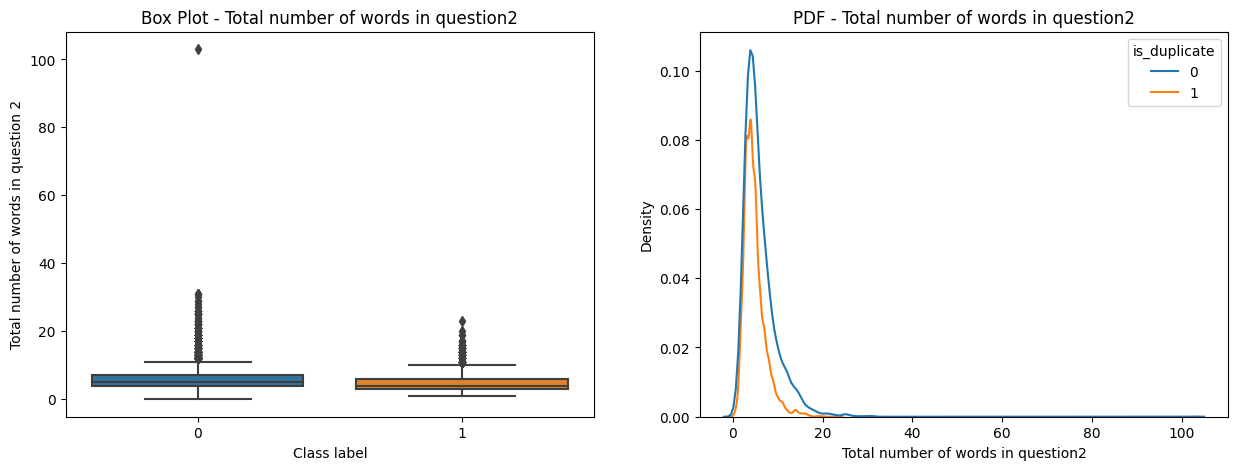

In [33]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='total_number_of_words_in_q2' , data=df)
plt.title('Box Plot - Total number of words in question2')
plt.xlabel('Class label')
plt.ylabel('Total number of words in question 2')

plt.subplot(1,2,2)

sns.kdeplot(x='total_number_of_words_in_q2' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Total number of words in question2')
plt.xlabel('Total number of words in question2')

plt.show()

<ipython-input-34-dc2c7707ace5>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='sum_of_total_words_of_q1_and_q2' , hue='is_duplicate' , data=df , shade=False)


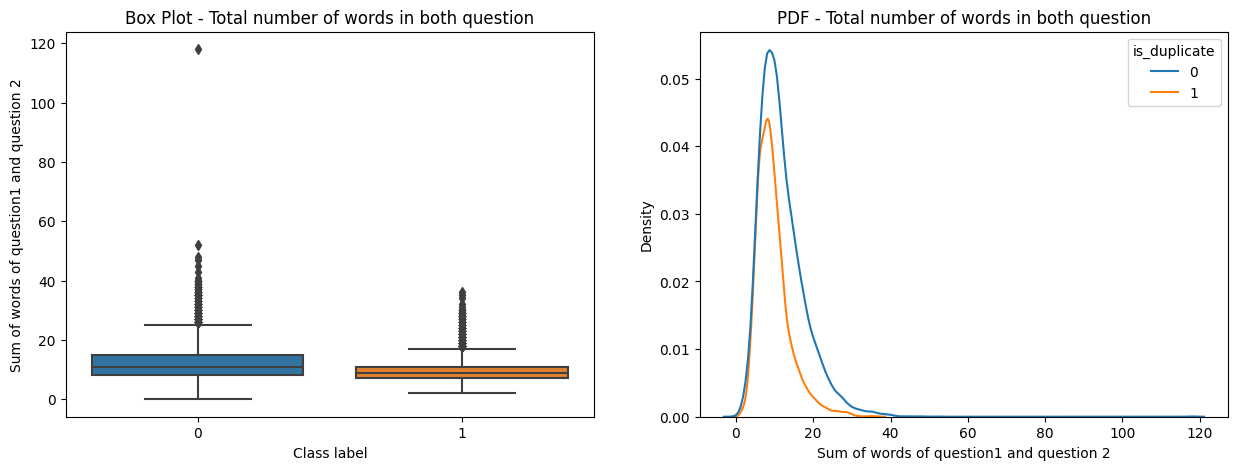

In [34]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='sum_of_total_words_of_q1_and_q2' , data=df)
plt.title('Box Plot - Total number of words in both question')
plt.xlabel('Class label')
plt.ylabel('Sum of words of question1 and question 2')

plt.subplot(1,2,2)

sns.kdeplot(x='sum_of_total_words_of_q1_and_q2' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Total number of words in both question')
plt.xlabel('Sum of words of question1 and question 2')

plt.show()

<ipython-input-35-ffeb440c473a>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='number_of_unique_words_in_q1' , hue='is_duplicate' , data=df , shade=False)


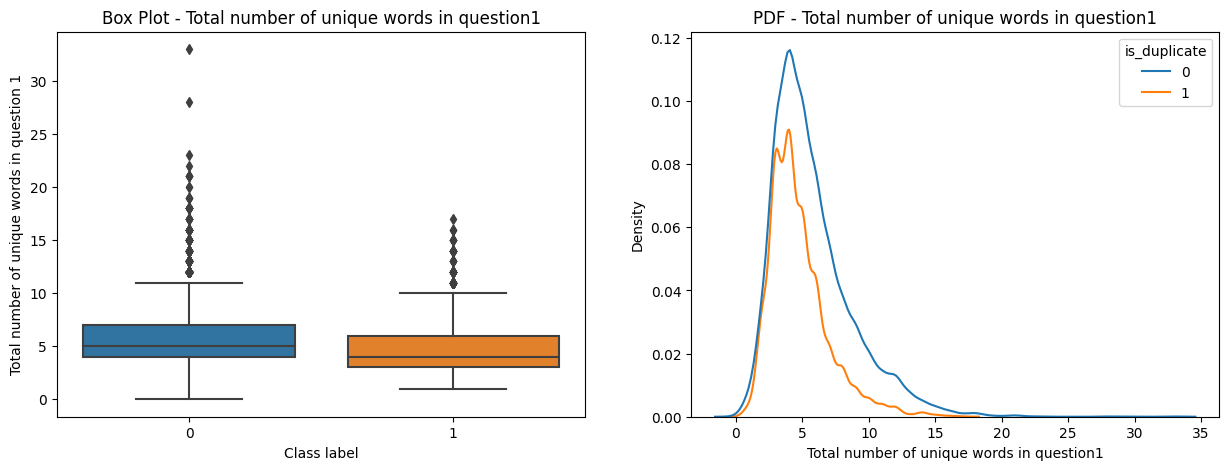

In [35]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='number_of_unique_words_in_q1' , data=df)
plt.title('Box Plot - Total number of unique words in question1')
plt.xlabel('Class label')
plt.ylabel('Total number of unique words in question 1')

plt.subplot(1,2,2)

sns.kdeplot(x='number_of_unique_words_in_q1' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Total number of unique words in question1')
plt.xlabel('Total number of unique words in question1')

plt.show()

<ipython-input-36-79e6f04e42ed>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='number_of_unique_words_in_q2' , hue='is_duplicate' , data=df , shade=False)


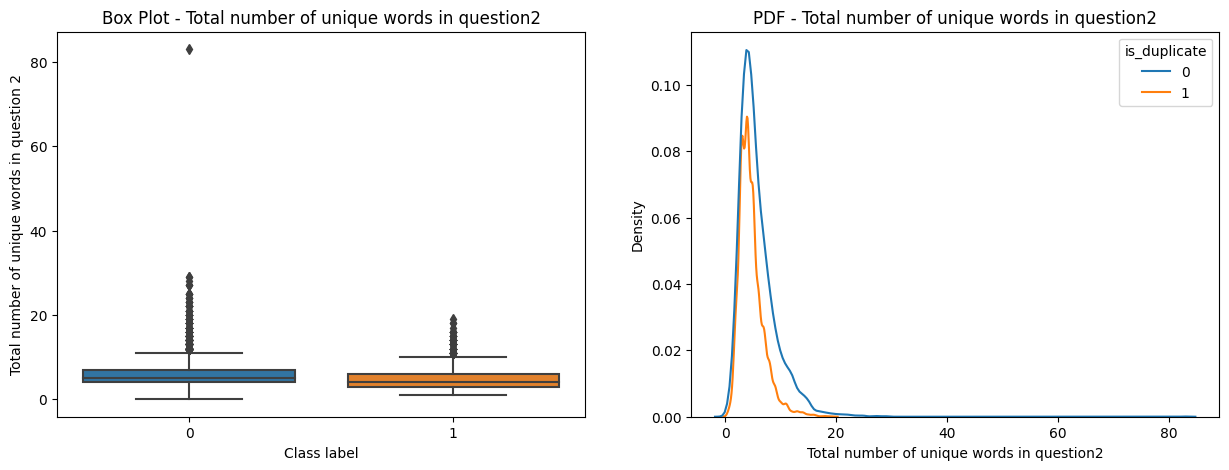

In [36]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='number_of_unique_words_in_q2' , data=df)
plt.title('Box Plot - Total number of unique words in question2')
plt.xlabel('Class label')
plt.ylabel('Total number of unique words in question 2')

plt.subplot(1,2,2)

sns.kdeplot(x='number_of_unique_words_in_q2' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Total number of unique words in question2')
plt.xlabel('Total number of unique words in question2')

plt.show()

<ipython-input-37-d33656ada2a4>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='sum_of_total_uinque_words_of_q1_and_q2' , hue='is_duplicate' , data=df , shade=False)


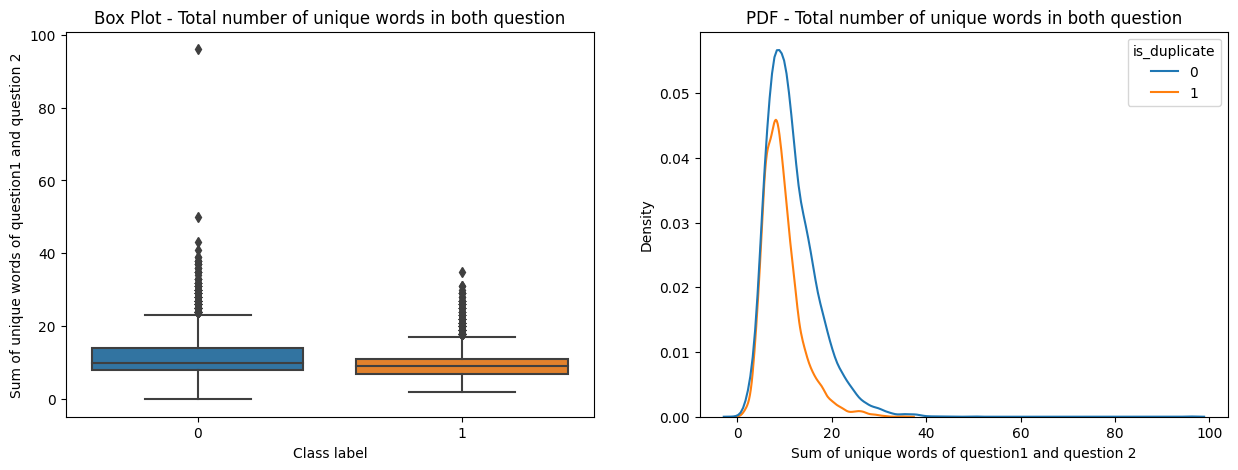

In [37]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='sum_of_total_uinque_words_of_q1_and_q2' , data=df)
plt.title('Box Plot - Total number of unique words in both question')
plt.xlabel('Class label')
plt.ylabel('Sum of unique words of question1 and question 2')

plt.subplot(1,2,2)

sns.kdeplot(x='sum_of_total_uinque_words_of_q1_and_q2' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Total number of unique words in both question')
plt.xlabel('Sum of unique words of question1 and question 2')

plt.show()

<ipython-input-38-5cfcb45b06ef>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='ratio_of_total_unique_words_and_total_words', hue='is_duplicate' , data=df , shade=False)


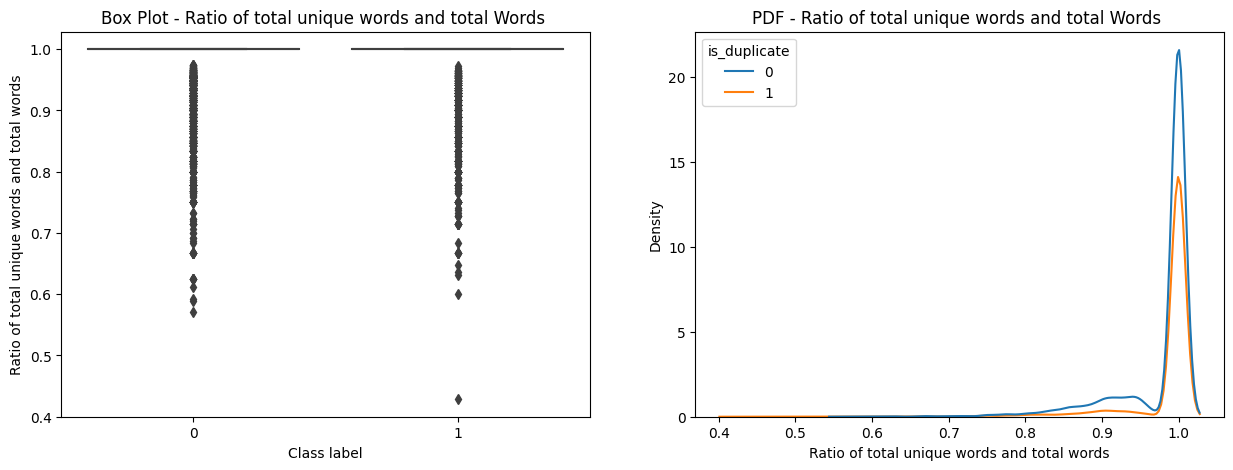

In [38]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='ratio_of_total_unique_words_and_total_words', data=df)
plt.title('Box Plot - Ratio of total unique words and total Words ')
plt.xlabel('Class label')
plt.ylabel('Ratio of total unique words and total words')

plt.subplot(1,2,2)

sns.kdeplot(x='ratio_of_total_unique_words_and_total_words', hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Ratio of total unique words and total Words ')
plt.xlabel('Ratio of total unique words and total words')

plt.show()

<ipython-input-39-2c745d575f2a>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='number_of_common_words_in_q1_and_q2', hue='is_duplicate' , data=df , shade=False)


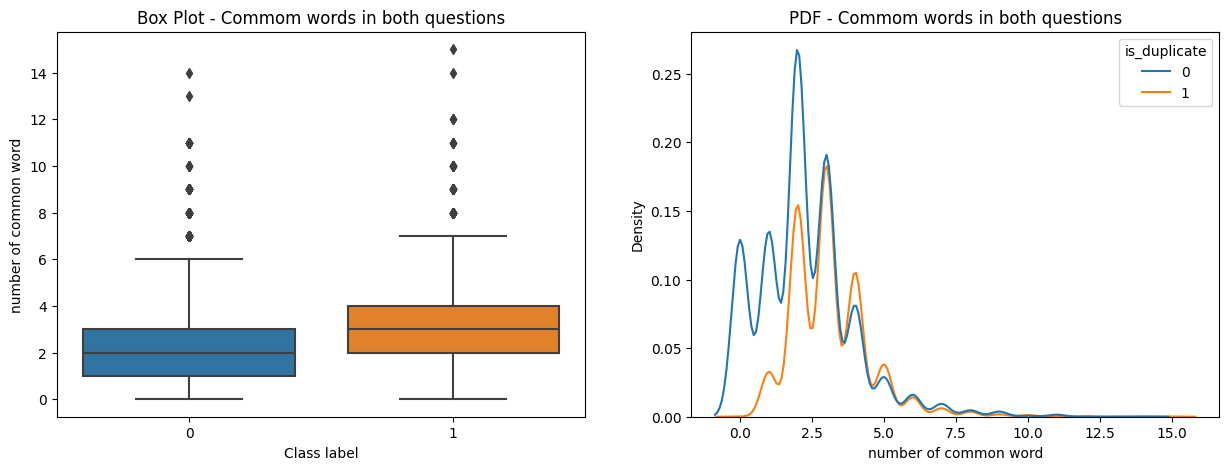

In [39]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='number_of_common_words_in_q1_and_q2', data=df)
plt.title('Box Plot - Commom words in both questions')
plt.xlabel('Class label')
plt.ylabel('number of common word')

plt.subplot(1,2,2)

sns.kdeplot(x='number_of_common_words_in_q1_and_q2', hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Commom words in both questions')
plt.xlabel('number of common word')

plt.show()

<ipython-input-40-95eb5b04d873>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='ratio_of_common_words_of_q1q2_and_total_words' , hue='is_duplicate' , data=df , shade=False)


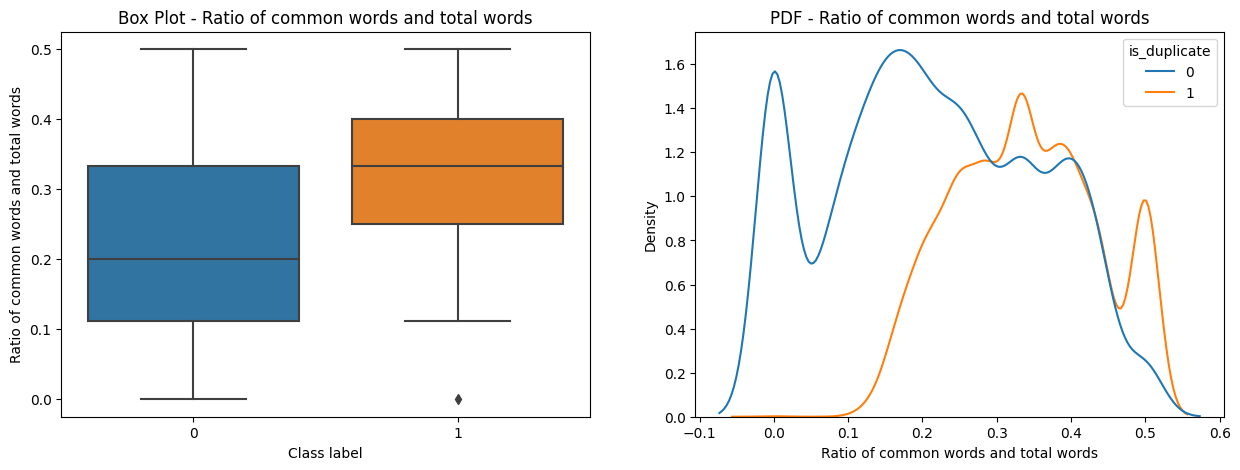

In [40]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='ratio_of_common_words_of_q1q2_and_total_words' , data=df)
plt.title('Box Plot - Ratio of common words and total words')
plt.xlabel('Class label')
plt.ylabel('Ratio of common words and total words')

plt.subplot(1,2,2)

sns.kdeplot(x='ratio_of_common_words_of_q1q2_and_total_words' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Ratio of common words and total words')
plt.xlabel('Ratio of common words and total words')

plt.show()

<ipython-input-41-e1323edbf420>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='ratio_of_common_words_of_q1q2_and_total_unique_words' , hue='is_duplicate' , data=df , shade=False)


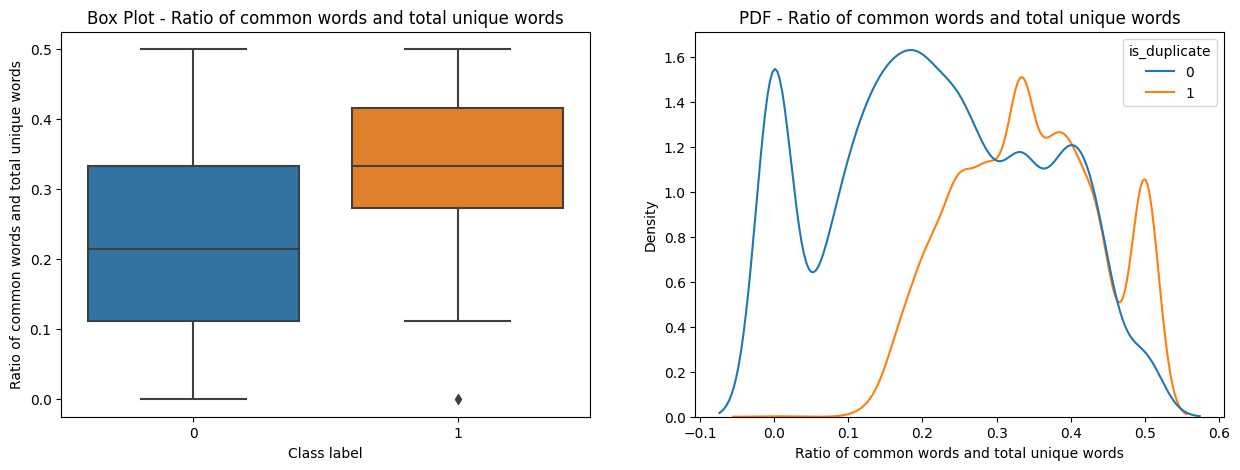

In [41]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='ratio_of_common_words_of_q1q2_and_total_unique_words' , data=df)
plt.title('Box Plot - Ratio of common words and total unique words')
plt.xlabel('Class label')
plt.ylabel('Ratio of common words and total unique words')

plt.subplot(1,2,2)

sns.kdeplot(x='ratio_of_common_words_of_q1q2_and_total_unique_words' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Ratio of common words and total unique words')
plt.xlabel('Ratio of common words and total unique words')

plt.show()

<ipython-input-42-9cb29541231c>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='ratio_of_common_words_and_length_of_smaller_question' , hue='is_duplicate' , data=df , shade=False)


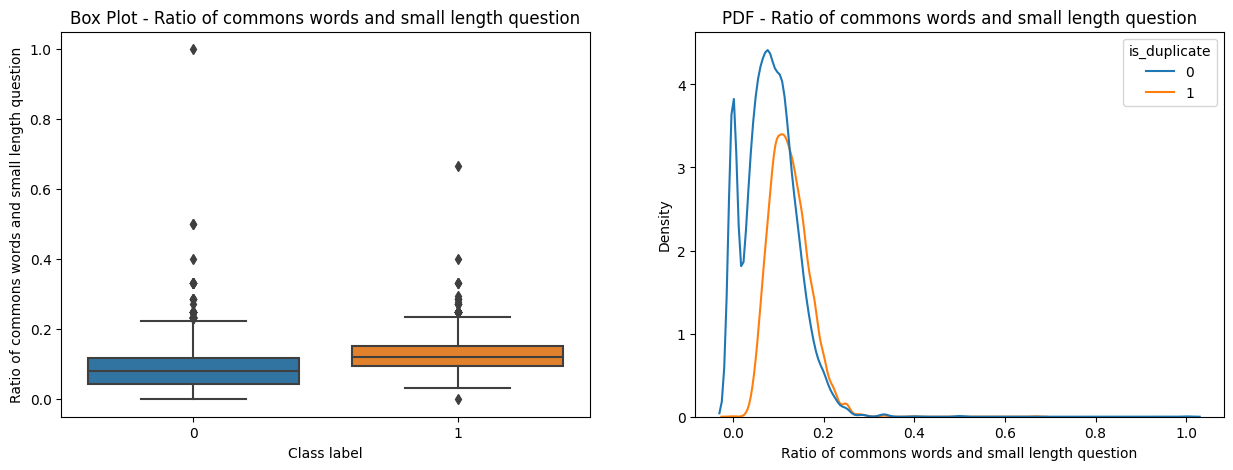

In [42]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='ratio_of_common_words_and_length_of_smaller_question' , data=df)
plt.title('Box Plot - Ratio of commons words and small length question')
plt.xlabel('Class label')
plt.ylabel('Ratio of commons words and small length question')

plt.subplot(1,2,2)

sns.kdeplot(x='ratio_of_common_words_and_length_of_smaller_question' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Ratio of commons words and small length question')
plt.xlabel('Ratio of commons words and small length question')

plt.show()

<ipython-input-43-c750c4e98195>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='ratio_of_common_words_and_length_of_larger_question' , hue='is_duplicate' , data=df , shade=False)


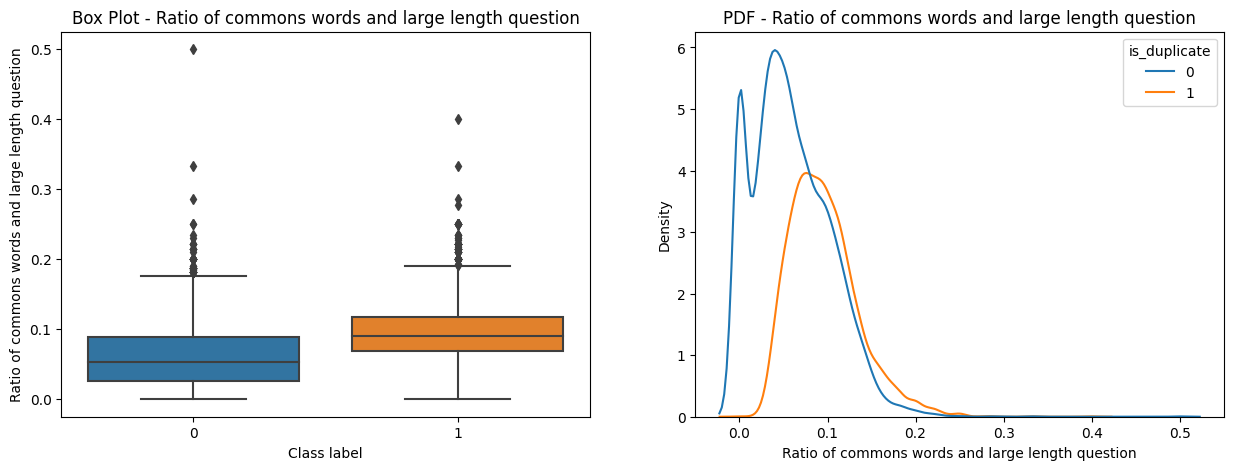

In [43]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='ratio_of_common_words_and_length_of_larger_question' , data=df)
plt.title('Box Plot - Ratio of commons words and large length question')
plt.xlabel('Class label')
plt.ylabel('Ratio of commons words and large length question')

plt.subplot(1,2,2)

sns.kdeplot(x='ratio_of_common_words_and_length_of_larger_question' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Ratio of commons words and large length question')
plt.xlabel('Ratio of commons words and large length question')

plt.show()

<ipython-input-44-849bb1559603>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='fuzz_ratio' , hue='is_duplicate' , data=df , shade=False)


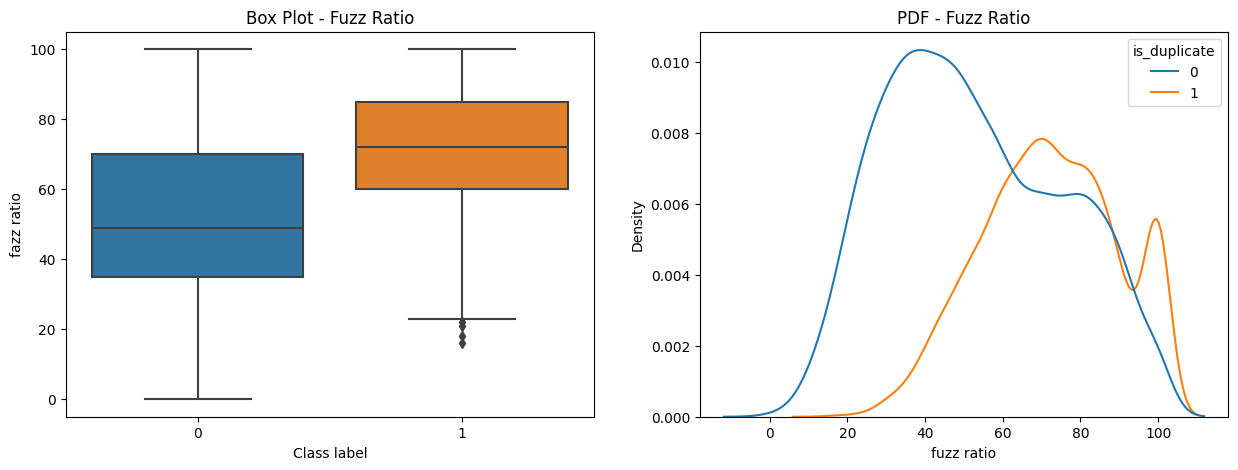

In [44]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='fuzz_ratio' , data=df)
plt.title('Box Plot - Fuzz Ratio')
plt.xlabel('Class label')
plt.ylabel('fazz ratio')

plt.subplot(1,2,2)

sns.kdeplot(x='fuzz_ratio' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Fuzz Ratio')
plt.xlabel('fuzz ratio')

plt.show()

<ipython-input-45-38757bec1af1>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='fuzz_partial_ratio' , hue='is_duplicate' , data=df , shade=False)


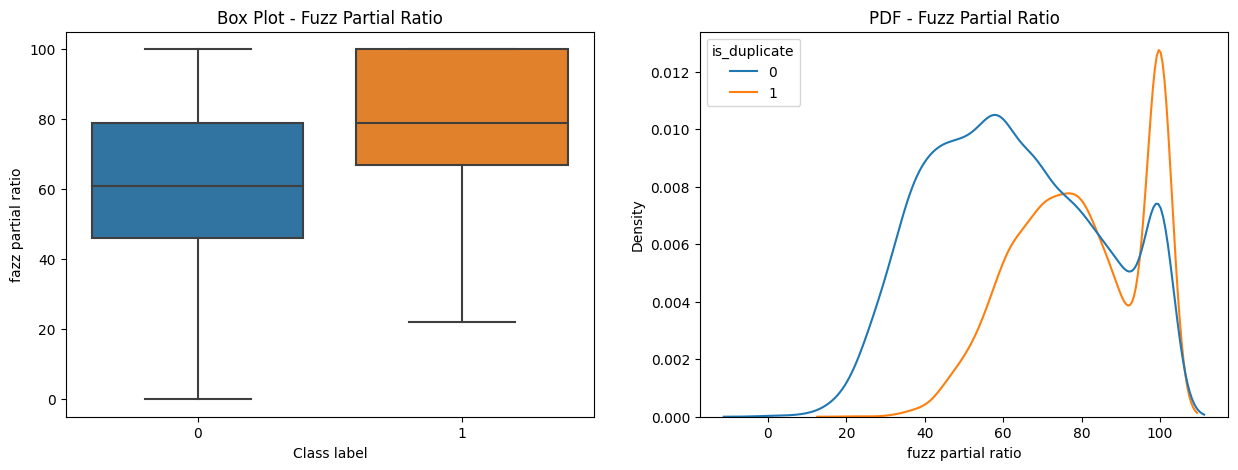

In [45]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='fuzz_partial_ratio' , data=df)
plt.title('Box Plot - Fuzz Partial Ratio')
plt.xlabel('Class label')
plt.ylabel('fazz partial ratio')

plt.subplot(1,2,2)

sns.kdeplot(x='fuzz_partial_ratio' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Fuzz Partial Ratio')
plt.xlabel('fuzz partial ratio')

plt.show()

<ipython-input-46-59534f65647e>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='fuzz_token_sort_ratio' , hue='is_duplicate' , data=df , shade=False)


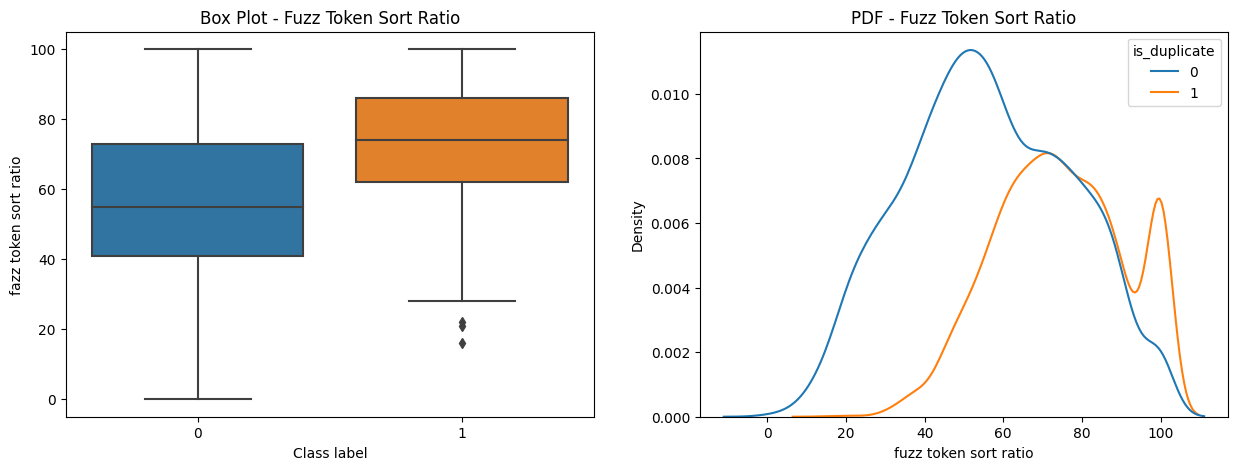

In [46]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='fuzz_token_sort_ratio' , data=df)
plt.title('Box Plot - Fuzz Token Sort Ratio')
plt.xlabel('Class label')
plt.ylabel('fazz token sort ratio')

plt.subplot(1,2,2)

sns.kdeplot(x='fuzz_token_sort_ratio' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Fuzz Token Sort Ratio')
plt.xlabel('fuzz token sort ratio')

plt.show()

<ipython-input-47-d79fb035fa91>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x='fuzz_token_set_ratio' , hue='is_duplicate' , data=df , shade=False)


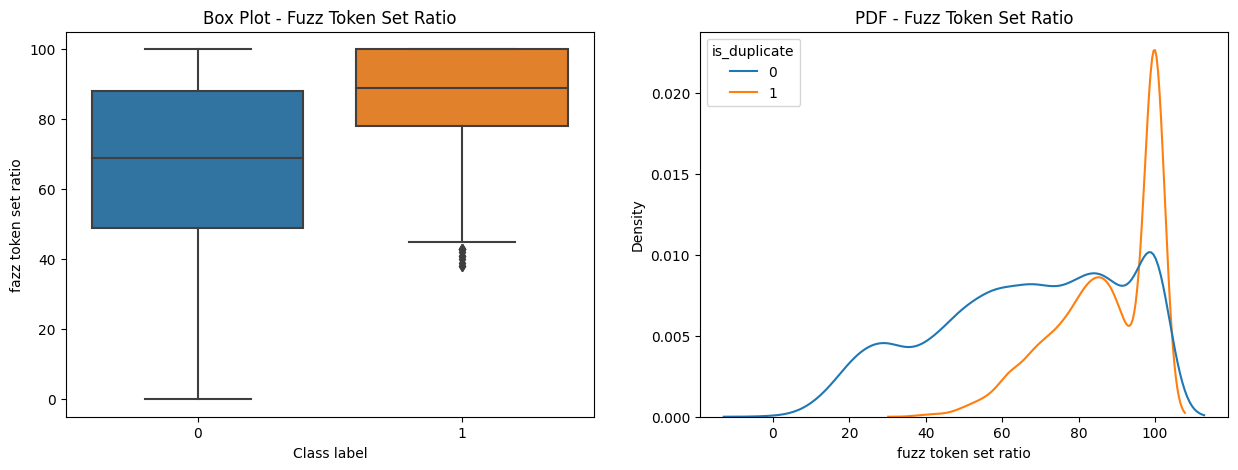

In [47]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

sns.boxplot(x='is_duplicate' , y='fuzz_token_set_ratio' , data=df)
plt.title('Box Plot - Fuzz Token Set Ratio')
plt.xlabel('Class label')
plt.ylabel('fazz token set ratio')

plt.subplot(1,2,2)

sns.kdeplot(x='fuzz_token_set_ratio' , hue='is_duplicate' , data=df , shade=False)
plt.title('PDF - Fuzz Token Set Ratio')
plt.xlabel('fuzz token set ratio')

plt.show()

### Due to same distribution droping some features

In [48]:
#'ratio_of_common_words_of_q1q2_and_total_words' and 'ratio_of_common_words_of_q1q2_and_total_unique_words'
# features are giving same distribution so droping
# 'ratio_of_common_words_of_q1q2_and_total_unique_words' feature

df = df.drop('ratio_of_common_words_of_q1q2_and_total_unique_words' , axis=1)
df.shape


(10000, 23)

In [49]:
# 'fuzz_ratio' and 'fuzz_token_sort_ratio'
# features are giving same distribution so droping 'fuzz_ratio'

df = df.drop('fuzz_ratio' , axis=1)
df.shape

(10000, 22)

In [50]:
df['question1'] = df['question1'].apply(lambda text : str(text))
df['question2'] = df['question2'].apply(lambda text : str(text))

In [51]:
df.shape

(10000, 22)

### Showing Worlcloud

In [52]:
from wordcloud import WordCloud

In [53]:
duplicate = df[df['is_duplicate']==1]
non_duplicate = df[df['is_duplicate']==0]

duplicate = np.array([duplicate['question1'] , duplicate['question2']]).flatten()
non_duplicate = np.array([non_duplicate['question1'], non_duplicate['question2']]).flatten()

dup_str = ' '.join(duplicate)
non_dup_str = ' '.join(non_duplicate)

stop_words = set(stopwords.words('english'))



Word cloud for duplicate pairs


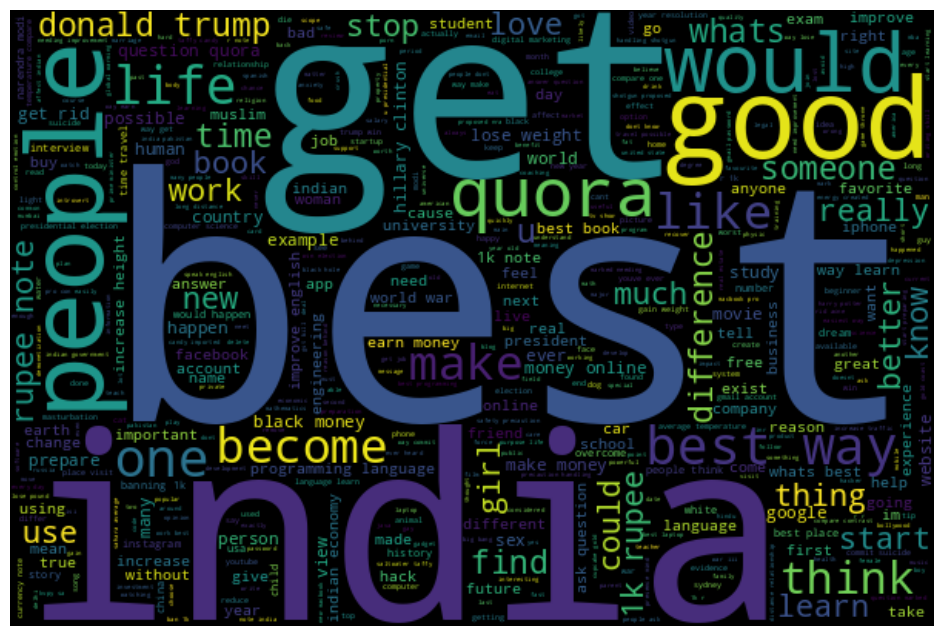

In [54]:
word_cloud = WordCloud(background_color='black' , max_words=len(dup_str) , stopwords=stop_words , width=600 , height=400)
word_cloud.generate(dup_str)

print('Word cloud for duplicate pairs')
plt.figure(figsize=(15,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

plt.show()

Word cloud for non duplicate pairs


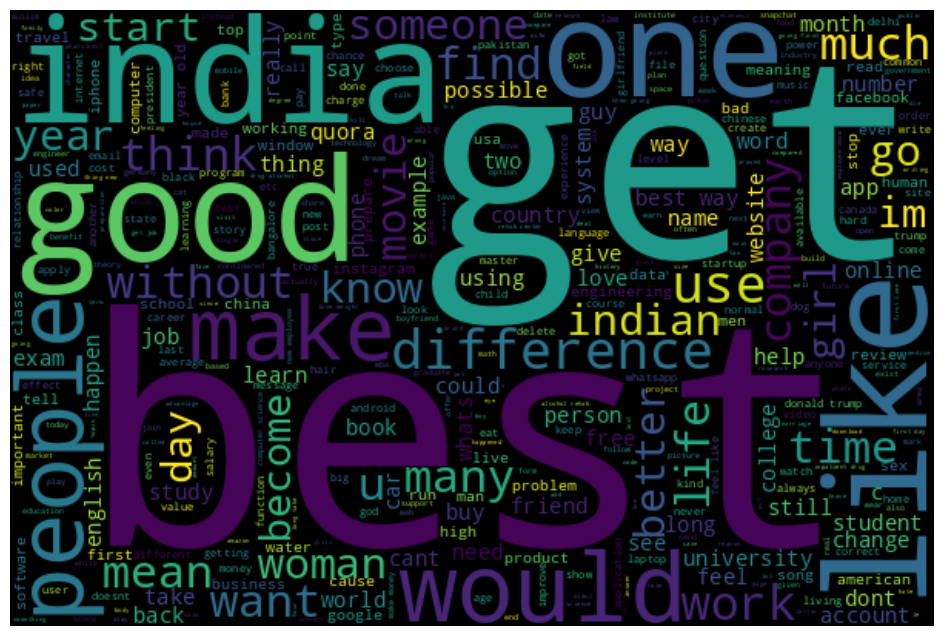

In [55]:
word_cloud = WordCloud(background_color='black' , max_words=len(dup_str) , stopwords=stop_words , width=600 , height=400)
word_cloud.generate(non_dup_str)

print('Word cloud for non duplicate pairs')
plt.figure(figsize=(15,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

plt.show()

## Vectorization

In [56]:
from numpy import vectorize
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import spacy

In [57]:
nlp = spacy.load('en_core_web_sm')

In [58]:
# Merge texts
questions = list(data['question1'])+list(data['question2'])

tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)

#  dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

In [59]:
vecs1 = []

for qu1 in tqdm(list(data['question1'])):
    doc1 = nlp(qu1)
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # Word2Vec
        vec1 = word1.vector
        # Fetch df score
        try: idf = word2tfidf[str(word1)]
        except: idf = 0
        # Compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
data['q1_feats_m'] = list(vecs1)


100%|██████████| 10000/10000 [01:18<00:00, 127.69it/s]


In [60]:
data.shape

(10000, 7)

In [62]:
vecs2 = []
for qu2 in tqdm(list(data['question2'])):
    doc2 = nlp(qu2)
    mean_vec2 = np.zeros([len(doc1), len(doc2[0].vector)])
    for word2 in doc2:
        # Word2Vec
        vec2 = word2.vector
        # Fetch df score
        try: idf = word2tfidf[str(word2)]
        except: idf = 0
        # Compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
data['q2_feats_m'] = list(vecs2)

100%|██████████| 10000/10000 [01:27<00:00, 114.04it/s]


In [63]:
df10 = pd.DataFrame(vecs1)
df10.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,16.193162,-46.322173,9.841352,-19.636256,15.854983,-11.241818,45.785663,33.625696,-1.234905,10.737043,...,10.017489,-33.312801,-48.736510,23.420135,-20.894435,9.537013,43.307022,68.755251,-16.548266,33.545764
1,-13.749575,-21.039634,17.504377,32.192824,26.810631,8.523536,18.733866,49.041140,3.269113,-39.369664,...,-4.886499,18.899583,-34.613992,29.855631,-12.093244,4.752864,75.213557,3.925738,0.363422,76.872173
2,-17.170065,-9.172638,-9.402203,-9.454547,9.582506,-14.595562,23.810517,13.145908,-18.881443,2.867223,...,28.195217,-0.677102,-24.089963,15.503159,-19.679583,-20.568814,27.755293,41.861482,-18.281855,29.983678
3,60.784047,-18.610806,-11.415927,-12.838112,-25.801177,-20.637659,12.124446,10.082246,16.141092,-6.874039,...,-16.098823,-2.123485,3.503274,42.186058,47.872763,-28.950629,29.495550,27.674547,1.260135,15.962171
4,-15.102233,-38.412432,1.925772,-35.750014,-35.249467,13.951096,43.572679,77.579965,9.257859,-12.459032,...,-12.589827,-14.178441,-47.946016,92.066145,-28.701434,31.443657,80.792530,70.162274,4.561526,82.467237


In [64]:
data.shape

(10000, 8)

In [65]:
df1 = df.drop(['qid1' , 'qid2' , 'question1' , 'question2'] , axis=1)
df2 = data.drop(['qid1' , 'qid2' , 'question1' , 'question2' , 'is_duplicate'], axis=1)

In [66]:
print(df1.shape)
print(df2.shape)

(10000, 18)
(10000, 3)


In [67]:
df2_q1 = pd.DataFrame(df2.q1_feats_m.values.tolist() , index = df2.index)
df2_q2 = pd.DataFrame(df2.q2_feats_m.values.tolist() , index = df2.index)

In [68]:
print(df2_q1.shape)
print(df2_q2.shape)

(10000, 96)
(10000, 96)


In [69]:
df2_q1['id'] = df1['id']
df2_q2['id'] = df1['id']

In [70]:
df2 = df2_q1.merge(df2_q2 , on='id' , how='left')

In [71]:
df2.shape

(10000, 193)

In [72]:
result = df1.merge(df2 , on='id' , how='left')

In [73]:
result.shape

(10000, 210)

In [74]:
result.head()

,id,is_duplicate,length_of_q1,length_of_q2,total_number_of_words_in_q1,total_number_of_words_in_q2,sum_of_total_words_of_q1_and_q2,number_of_unique_words_in_q1,number_of_unique_words_in_q2,sum_of_total_uinque_words_of_q1_and_q2,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,41,35,7,6,13,6,5,11,...,12.484386,-30.107836,-48.081679,14.703115,-17.445700,6.489429,26.232975,63.744263,-17.358652,21.569600
1,1,0,31,67,4,9,13,3,8,11,...,5.320119,14.133854,-32.888437,41.303056,-3.310772,3.920682,69.740691,32.594035,-0.615386,73.702751
2,2,0,44,36,6,5,11,6,5,11,...,48.658139,-11.683637,-48.716567,11.563160,-18.226036,-5.445120,45.495341,47.005359,-6.413416,10.433740
3,3,0,21,40,3,5,8,3,5,8,...,22.669657,9.725057,-6.863062,22.075064,0.805945,-18.431798,9.483196,42.611737,5.462952,31.786348
4,4,0,60,29,10,5,15,10,5,15,...,-4.280166,-13.787703,-25.602232,12.989551,-11.180959,-3.175036,35.884318,35.931497,-10.196204,16.758218


In [75]:
result.isnull().sum().sum()

6

In [76]:
result = result.dropna()

In [77]:
result.shape

(9997, 210)

## Data splitting

In [95]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
!pip install catboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
import catboost

In [79]:
result = result.drop('id' , axis=1)

In [80]:
X = result.drop('is_duplicate' , axis=1)
Y = result['is_duplicate']

In [81]:
print(X.shape , Y.shape)

(9997, 208) (9997,)


In [82]:
x_train , x_test , y_train , y_test = train_test_split(X , Y , test_size=0.4 , random_state=1)

In [83]:
print(x_train.shape , x_test.shape , y_train.shape , y_test.shape)

(5998, 208) (3999, 208) (5998,) (3999,)


## Error Analysis

In [84]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    log_loss,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:

class EvaluateModel:
    def __init__(self, x_test, y_test, model):
        self.x_test = x_test
        self.y_test = y_test
        self.model = model

    def evaluate_model(self):
        print("Evaluating the model:- ")
        y_pred = self.model.predict(self.x_test)
        print("Accuracy Score:- ", accuracy_score(self.y_test, y_pred))
        print("Precision Score:- ", precision_score(self.y_test, y_pred))
        print("Recall Score:- ", recall_score(self.y_test, y_pred))
        print("F1 Score:- ", f1_score(self.y_test, y_pred))
        print(
            "Log Loss:- ", log_loss(self.y_test, self.model.predict_proba(self.x_test))
        )
        print("Completed evaluating the model")

    def plot_confusion_matrix(self, test_y, predict_y):
        confusion = confusion_matrix(test_y, predict_y)

        Recall = ((confusion.T) / (confusion.sum(axis=1))).T
        # divide each element of the confusion matrix with the sum of elements in that column

        Precision = confusion / confusion.sum(axis=0)
        # divide each element of the confusion matrix with the sum of elements in that row

        plt.figure(figsize=(20, 4))

        labels = [0, 1]
        cmap = sns.light_palette("blue")
        plt.subplot(1, 3, 1)
        sns.heatmap(
            confusion,
            annot=True,
            cmap=cmap,
            fmt=".3f",
            xticklabels=labels,
            yticklabels=labels,
        )
        plt.xlabel("Predicted Class")
        plt.ylabel("Original Class")
        plt.title("Confusion matrix")

        plt.subplot(1, 3, 2)
        sns.heatmap(
            Precision,
            annot=True,
            cmap=cmap,
            fmt=".3f",
            xticklabels=labels,
            yticklabels=labels,
        )
        plt.xlabel("Predicted Class")
        plt.ylabel("Original Class")
        plt.title("Precision matrix")

        plt.subplot(1, 3, 3)
        sns.heatmap(
            Recall,
            annot=True,
            cmap=cmap,
            fmt=".3f",
            xticklabels=labels,
            yticklabels=labels,
        )
        plt.xlabel("Predicted Class")
        plt.ylabel("Original Class")
        plt.title("Recall matrix")

        plt.show()

    def plot_roc_curve(self, test_y, predict_y):
        auroc = roc_auc_score(test_y, predict_y)
        print("AUROC Score:- ", auroc)
        fpr, tpr, _ = roc_curve(test_y, predict_y)
        plt.plot(
            fpr, tpr, linestyle="--", label="Prediction_for_lr (AUROC = %0.3f)" % auroc
        )
        plt.title("ROC Plot")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

## SVM Model

Started training the model:- 
Completed training the model
Evaluating the model:- 
Accuracy Score:-  0.6219054763690923
Precision Score:-  0.0
Recall Score:-  0.0
F1 Score:-  0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Log Loss:-  0.6633887478642602
Completed evaluating the model


<ipython-input-85-08af0d0c97e5>:25: RuntimeWarning: invalid value encountered in divide
  Precision = confusion / confusion.sum(axis=0)


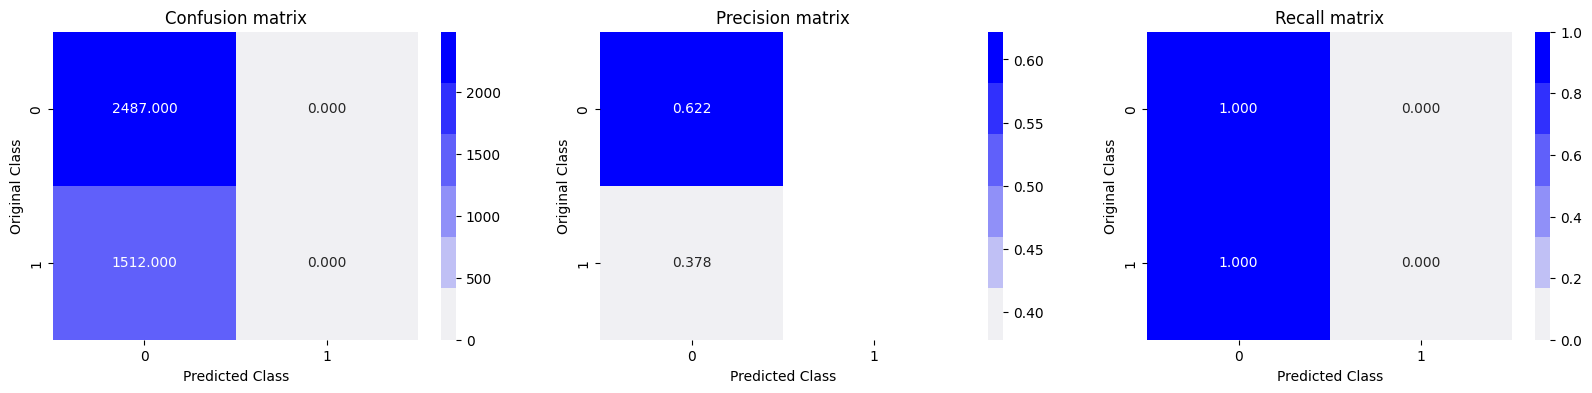

AUROC Score:-  0.5


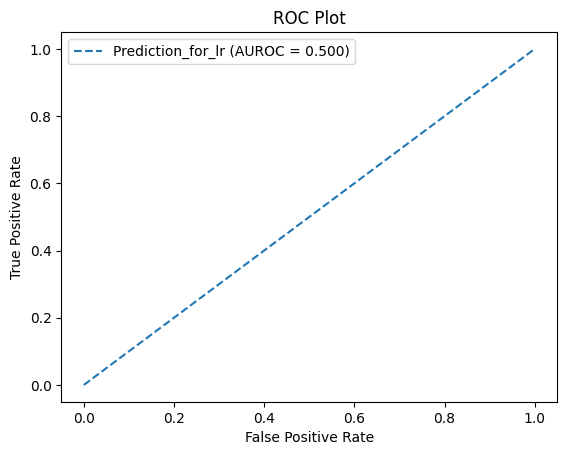

In [86]:
def svm_model(x_train , y_train , fine_tuning=True):
    if fine_tuning:
        print("Started Finetuning the model:- ")
        C = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        gamma = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        params = {
            "C": C,
            "gamma": gamma,
        }
        svm = SVC()
        clf = RandomizedSearchCV(svm, params, cv=5, n_jobs=-1)
        clf.fit(x_train,y_train)
        print("Finished Hyperparameter search")
        return clf
    else:
        print("Started training the model:- ")
        svm = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
            decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
            max_iter=-1, probability=True, random_state=None, shrinking=True,
            tol=0.001, verbose=False)
        svm.fit(x_train, y_train)
        print("Completed training the model")
        return svm
svm = svm_model(x_train , y_train , fine_tuning=False)
svm_predict = svm.predict(x_test)
evaluate_svm = EvaluateModel(x_test , y_test , svm)
evaluate_svm.evaluate_model()
evaluate_svm.plot_confusion_matrix(y_test , svm_predict)
evaluate_svm.plot_roc_curve(y_test , svm_predict)

## Logistic Regression

Training the model logistic regression model:- 
Completed training the model
Evaluating the model:- 
Accuracy Score:-  0.6939234808702176
Precision Score:-  0.6019830028328612
Recall Score:-  0.5621693121693122
F1 Score:-  0.5813953488372094
Log Loss:-  0.5458261479212249
Completed evaluating the model


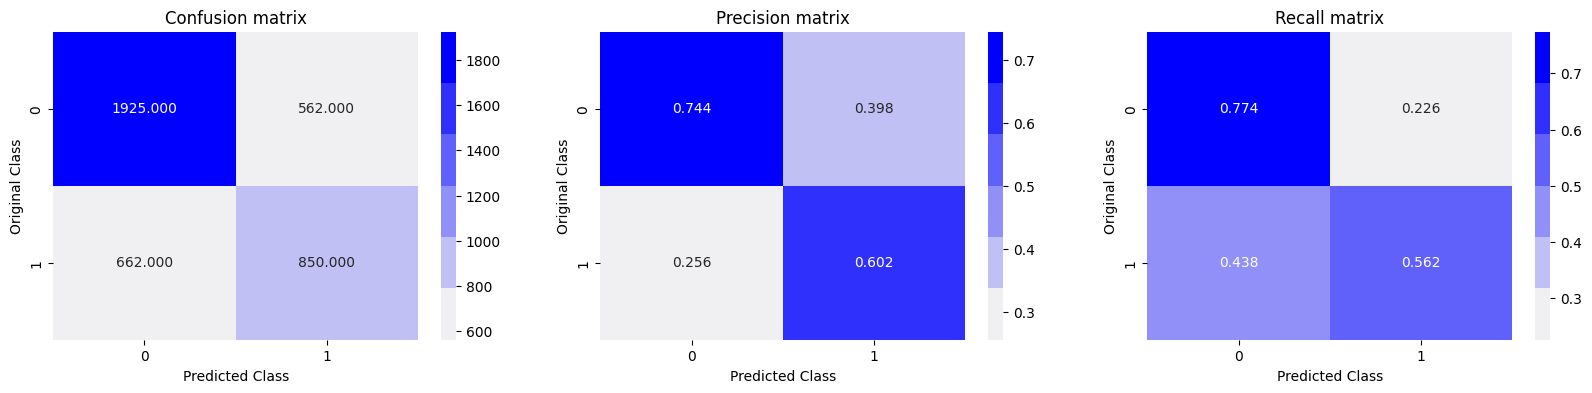

AUROC Score:-  0.6680971209017047


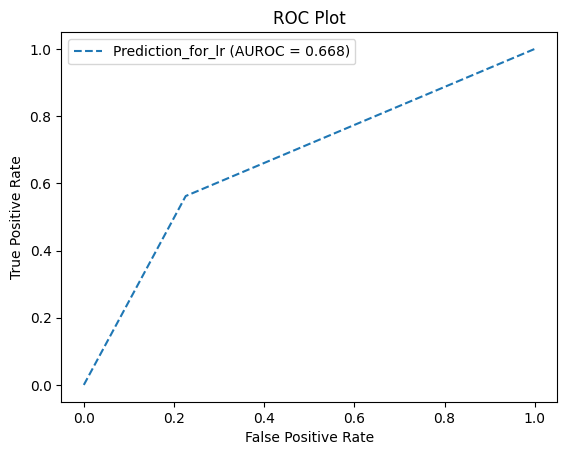

In [87]:
def logistic_regression_model(x_train , y_train):
    print("Training the model logistic regression model:- ")
    log_reg = LogisticRegression(max_iter=10000)
    log_reg.fit(x_train, y_train)

    print("Completed training the model")
    return log_reg
lr = logistic_regression_model(x_train , y_train)
lr_predict = lr.predict(x_test)
evaluate_lr = EvaluateModel(x_test , y_test , lr)
evaluate_lr.evaluate_model()
evaluate_lr.plot_confusion_matrix(y_test , lr_predict)
evaluate_lr.plot_roc_curve(y_test , lr_predict)

## Naive Bayes

Training the model naive bayes model:- 
Completed training the model
Evaluating the model:- 
Accuracy Score:-  0.4428607151787947
Precision Score:-  0.4025054466230937
Recall Score:-  0.9775132275132276
F1 Score:-  0.5702160493827161
Log Loss:-  0.8157080826692824
Completed evaluating the model


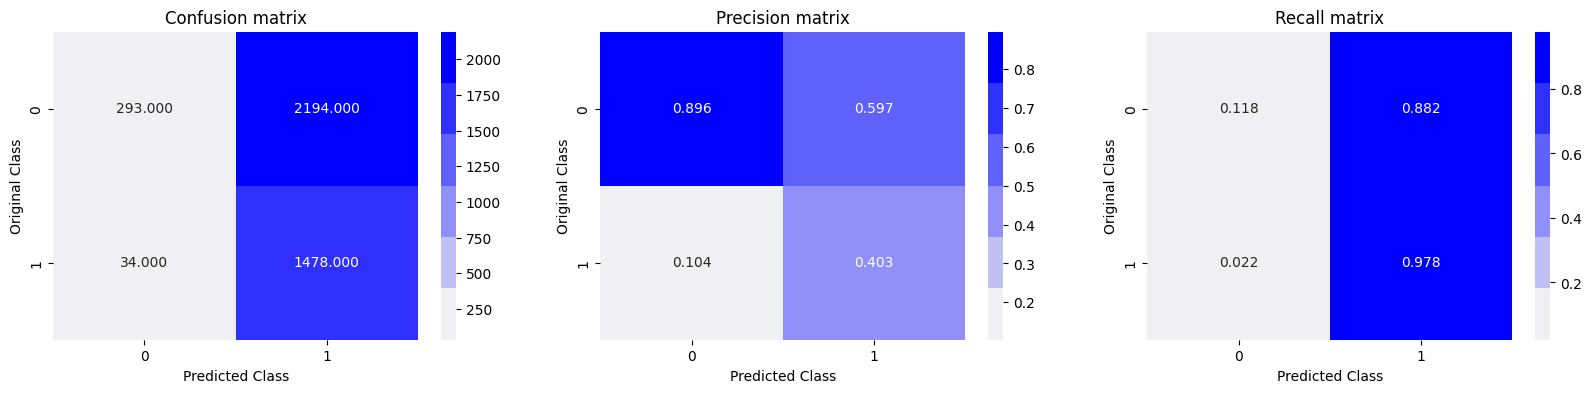

AUROC Score:-  0.5476629265833126


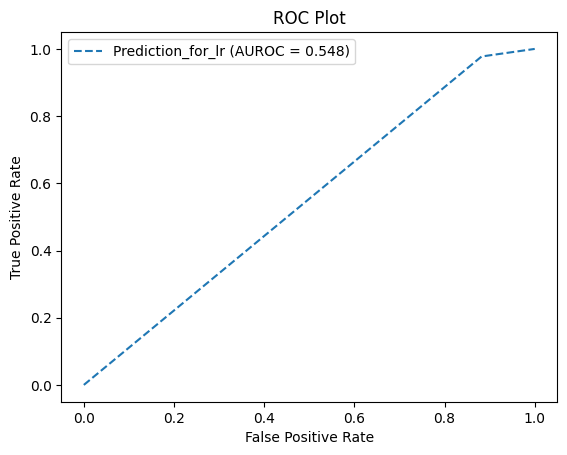

In [94]:
def naive_bayes(x_train , y_train):
  print("Training the model naive bayes model:- ")
  model = GaussianNB(var_smoothing=7.127035668355718)
  model.fit(x_train , y_train)
  print("Completed training the model")
  return model
nb = naive_bayes(x_train , y_train)
nb_predict = nb.predict(x_test)
evaluate_nb = EvaluateModel(x_test , y_test , nb)
evaluate_nb.evaluate_model()
evaluate_nb.plot_confusion_matrix(y_test , nb_predict)
evaluate_nb.plot_roc_curve(y_test , nb_predict)

## Decision Tree

Training the model Decision Trees model
Completed training the model
Evaluating the model:- 
Accuracy Score:-  0.6219054763690923
Precision Score:-  0.0
Recall Score:-  0.0
F1 Score:-  0.0
Log Loss:-  0.557163905443296
Completed evaluating the model


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-85-08af0d0c97e5>:25: RuntimeWarning: invalid value encountered in divide
  Precision = confusion / confusion.sum(axis=0)


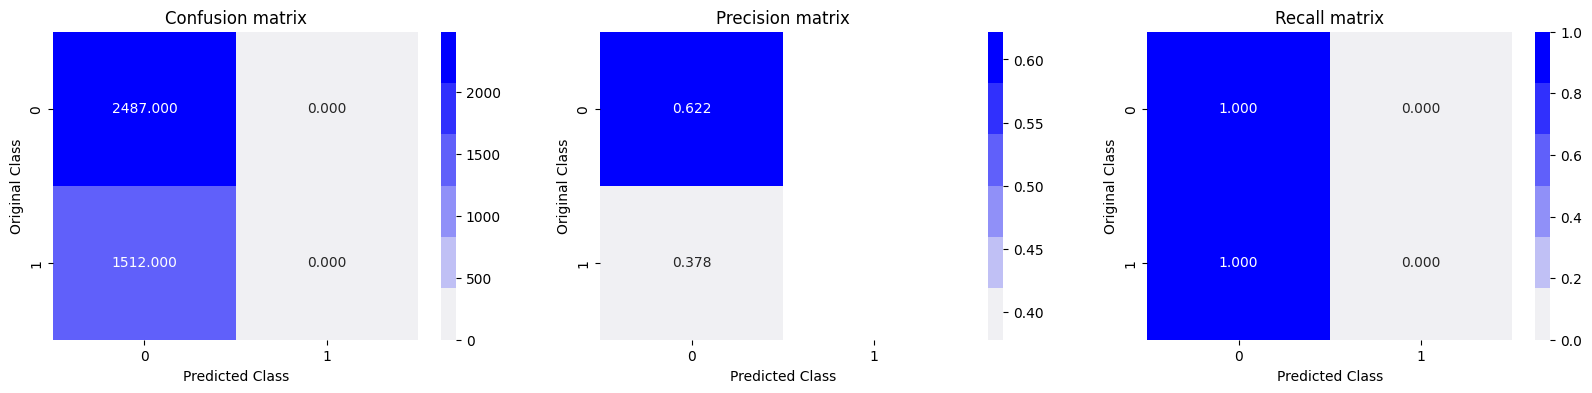

AUROC Score:-  0.5


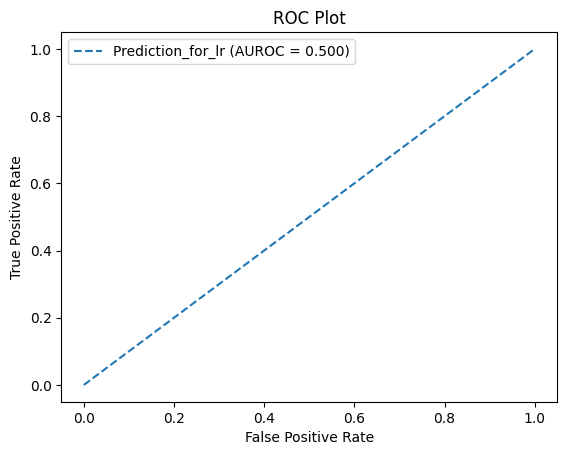

In [96]:
def decision_trees(x_train , y_train):
  print("Training the model Decision Trees model")
  model = DecisionTreeClassifier(
      criterion="entropy", max_depth=1, min_samples_split=7
    )
  model.fit(x_train , y_train)
  print("Completed training the model")
  return model
dt = decision_trees(x_train , y_train)
dt_predict = dt.predict(x_test)
evaluate_dt = EvaluateModel(x_test , y_test , dt)
evaluate_dt.evaluate_model()
evaluate_dt.plot_confusion_matrix(y_test , dt_predict)
evaluate_dt.plot_roc_curve(y_test , dt_predict)

## Random Forest

Training the model Random Forest model
Completed training the model
Evaluating the model:- 
Accuracy Score:-  0.7179294823705926
Precision Score:-  0.6403508771929824
Recall Score:-  0.5793650793650794
F1 Score:-  0.6083333333333333
Log Loss:-  0.5144434948391892
Completed evaluating the model


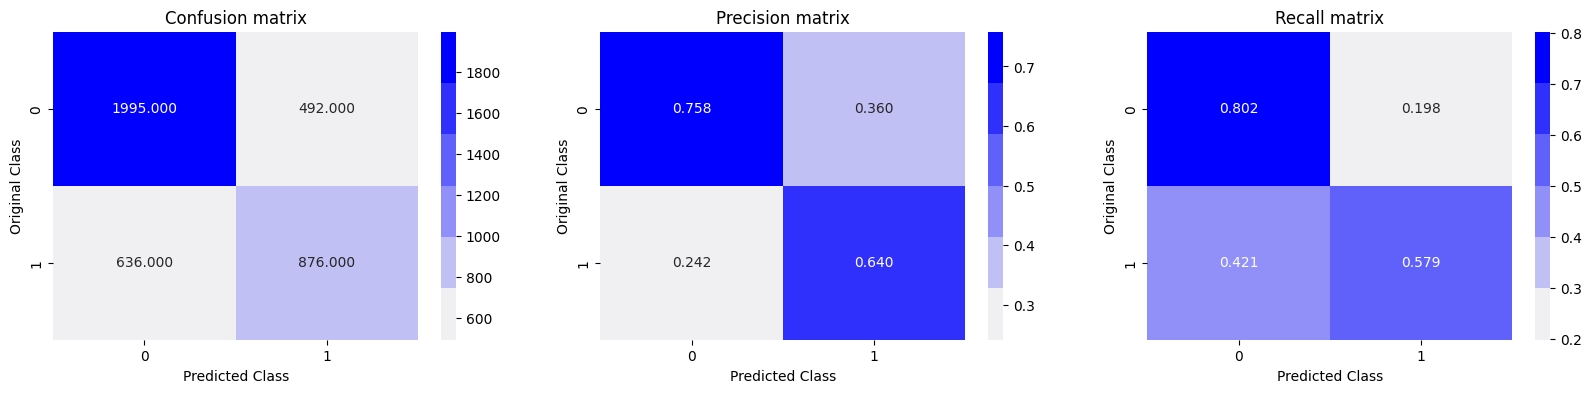

AUROC Score:-  0.6907681850383902


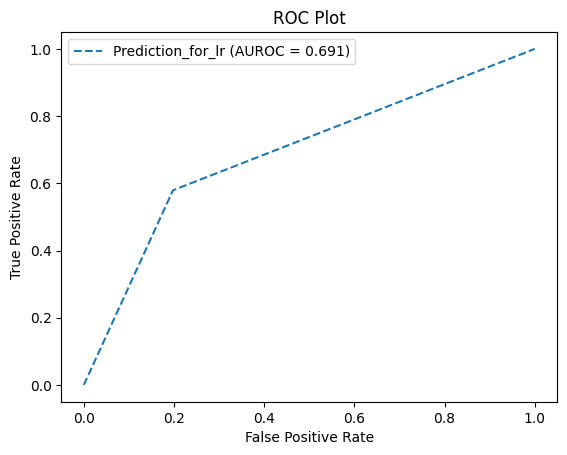

In [97]:
def random_forest(x_train , y_train):
  print("Training the model Random Forest model")
  model = RandomForestClassifier(
      n_estimators=92, max_depth=19, min_samples_split=4
      )
  model.fit(x_train , y_train)
  print("Completed training the model")
  return model
rf = random_forest(x_train , y_train)
rf_predict = rf.predict(x_test)
evaluate_rf = EvaluateModel(x_test , y_test , rf)
evaluate_rf.evaluate_model()
evaluate_rf.plot_confusion_matrix(y_test , rf_predict)
evaluate_rf.plot_roc_curve(y_test , rf_predict)

## Adaboost

Training the model AdaBoost model
Completed training the model
Evaluating the model:- 
Accuracy Score:-  0.7064266066516629
Precision Score:-  0.6110381077529566
Recall Score:-  0.6150793650793651
F1 Score:-  0.6130520764667108
Log Loss:-  0.6621459361363067
Completed evaluating the model


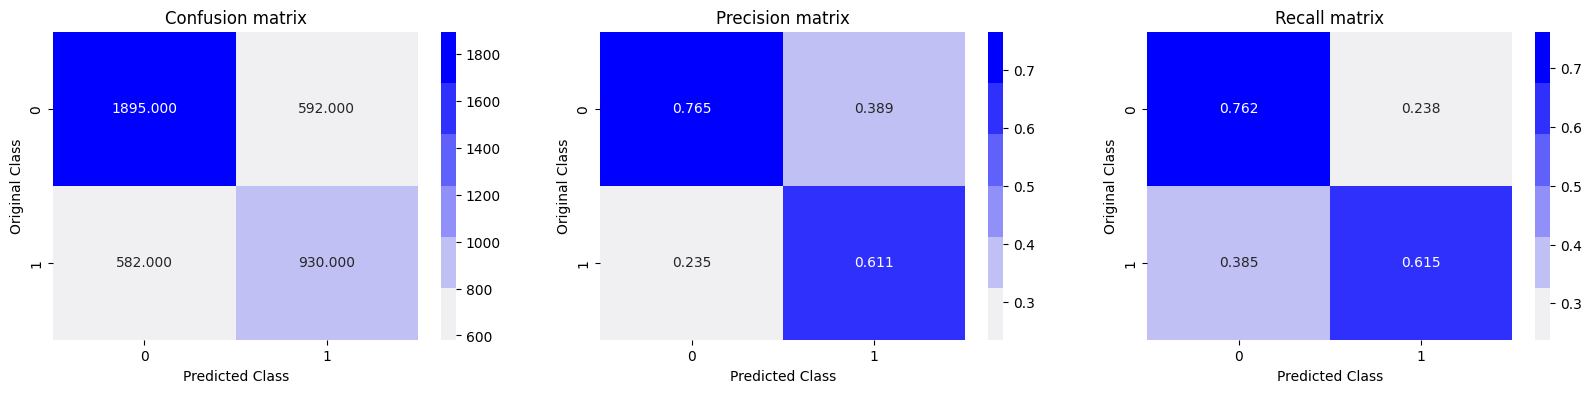

AUROC Score:-  0.6885207842686732


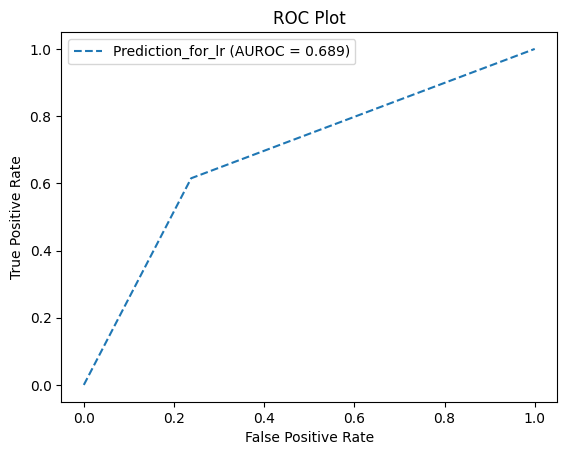

In [108]:
def adaboost(x_train , y_train):
  print("Training the model AdaBoost model")
  model = AdaBoostClassifier(
      n_estimators=143, learning_rate=0.2374269674908056
      )
  model.fit(x_train , y_train)
  print("Completed training the model")
  return model
ad = adaboost(x_train , y_train)
ad_predict = ad.predict(x_test)
evaluate_ad = EvaluateModel(x_test , y_test , ad)
evaluate_ad.evaluate_model()
evaluate_ad.plot_confusion_matrix(y_test , ad_predict)
evaluate_ad.plot_roc_curve(y_test , ad_predict)

## XGBoost

Started training the XgBoost model:- 
Completed training the XgBoost model
Evaluating the model:- 
Accuracy Score:-  0.7231807951987997
Precision Score:-  0.6395589248793935
Recall Score:-  0.6137566137566137
F1 Score:-  0.6263921700978738
Log Loss:-  0.5482940938048437
Completed evaluating the model


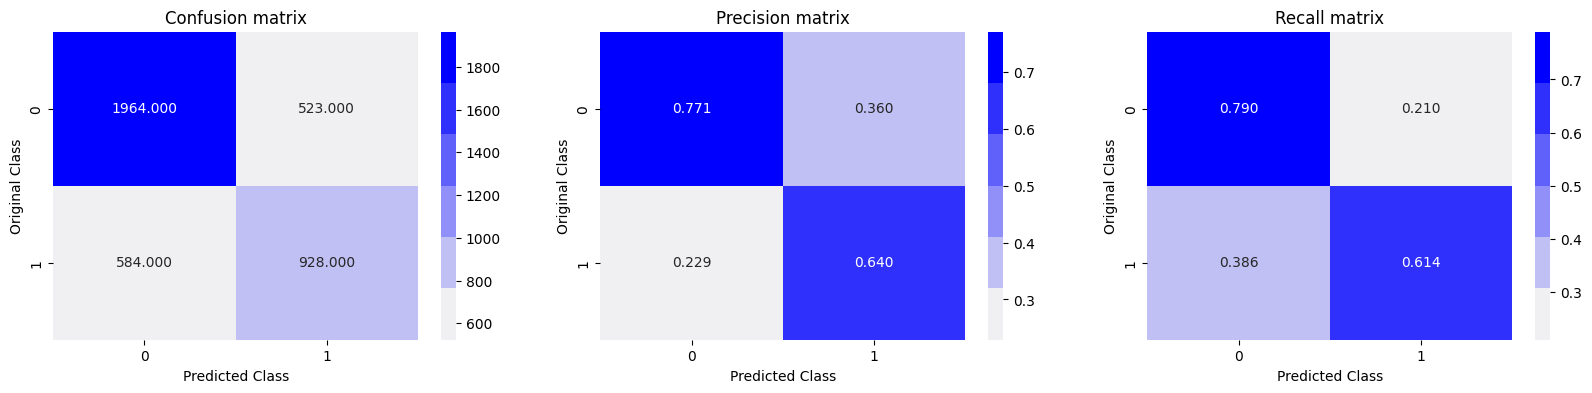

AUROC Score:-  0.7017315437098308


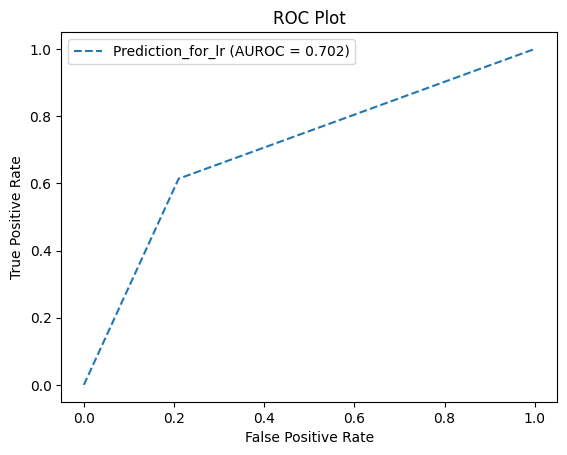

In [104]:
import joblib
def Xgboost_model(x_train , y_train):
  print("Started training the XgBoost model:- ")
  xgb = XGBClassifier(
      learning_rate=0.3,
      max_delta_step=0,
      max_depth=8,
      min_child_weight=1,
      n_estimators=50,
      n_jobs=16,
      num_parallel_tree=1,
      random_state=0,
      reg_alpha=0,
      reg_lambda=1,
      scale_pos_weight=1,
      subsample=1.0,
      tree_method="exact",
      validate_parameters=1,
      verbosity=None,
    )
  xgb.fit(x_train , y_train)
  print("Completed training the XgBoost model")
  joblib.dump(xgb , "xgb.pkl")
  return xgb
xgb = Xgboost_model(x_train , y_train)
xgb_predict = xgb.predict(x_test)
evaluate_xgb = EvaluateModel(x_test , y_test , xgb)
evaluate_xgb.evaluate_model()
evaluate_xgb.plot_confusion_matrix(y_test , xgb_predict)
evaluate_xgb.plot_roc_curve(y_test , xgb_predict)

## CatBoost

Started training the XgBoost model:- 
Completed training the XgBoost model
Evaluating the model:- 
Accuracy Score:-  0.7231807951987997
Precision Score:-  0.6395589248793935
Recall Score:-  0.6137566137566137
F1 Score:-  0.6263921700978738
Log Loss:-  0.5482940938048437
Completed evaluating the model


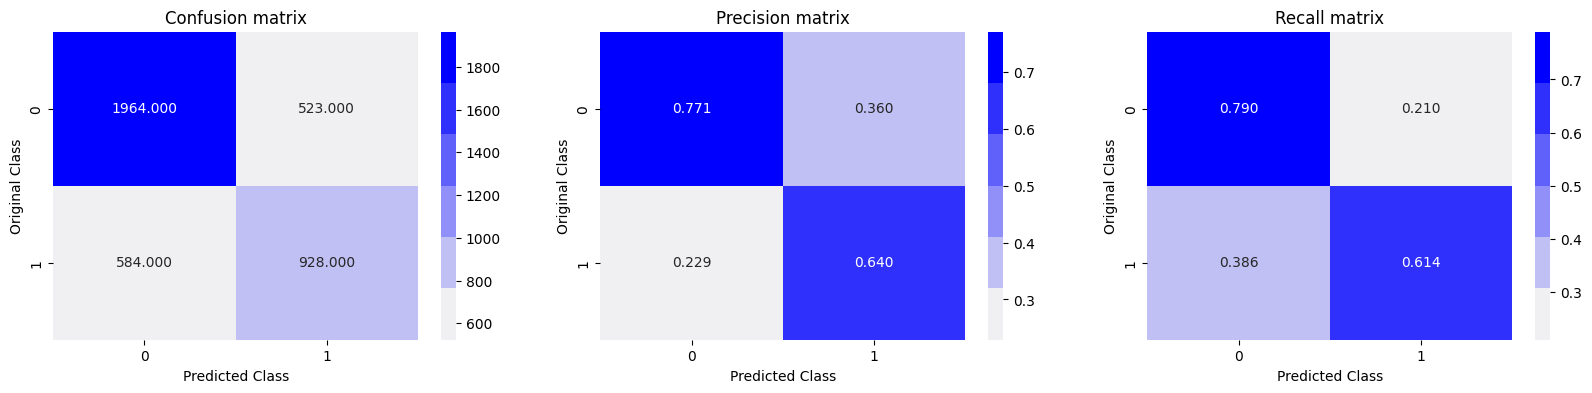

AUROC Score:-  0.7017315437098308


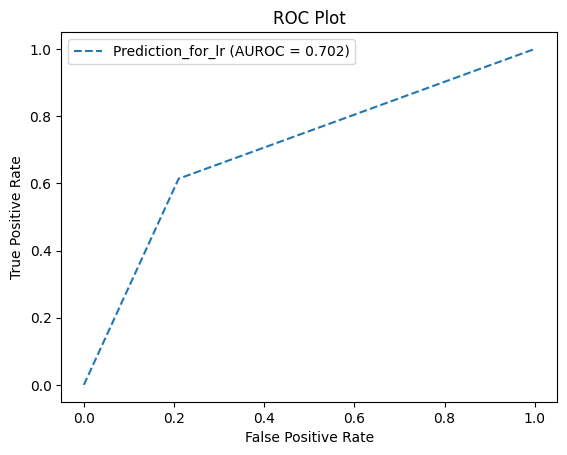

In [105]:
def catboost(x_train , y_train):
  print("Entered for training CatBoost model")
  clf = CatBoostClassifier(
      loss_function="Logloss",
      l2_leaf_reg=0.005603859124543057,
      max_bin=332,
      learning_rate=0.0075037108414941255,
      n_estimators=1297,
      max_depth=16,
      random_state=24,
      min_data_in_leaf=94,
  )
  clf.fit(x_train , y_train)
  print("Completed training the model")
  return clf
cb = Xgboost_model(x_train , y_train)
cb_predict = cb.predict(x_test)
evaluate_cb = EvaluateModel(x_test , y_test , cb)
evaluate_cb.evaluate_model()
evaluate_cb.plot_confusion_matrix(y_test , cb_predict)
evaluate_cb.plot_roc_curve(y_test , cb_predict)

## LSTM

### Create embedding matrix

In [116]:
df = pd.read_csv('https://raw.githubusercontent.com/DHRUVA-N-L-CHOUDHARY/text_alignment_analysis/main/train.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [117]:
df = df.dropna()

In [118]:
df = df.drop(['id', 'qid1','qid2','is_duplicate'], axis=1)


In [119]:
df['col'] = list(zip(df.question1, df.question2))
df = df.drop(['question1', 'question2'], axis=1)

In [120]:
df = df['col'].tolist()

In [121]:
predictions = model.predict(df)

print(predictions)

NameError: ignored

In [ ]:
df2 = pd.DataFrame({'col':df})
df2["result"] = predictions
df2

In [ ]:
df3 = pd.read_csv('https://raw.githubusercontent.com/Kirti1807/Quora-Question-Similarity-Pair/main/data/train.csv')
df2["is_duplicate"] = df3["is_duplicate"]
df2

In [ ]:
import seaborn as sns

In [ ]:
df2.to_csv("file.csv")

In [ ]:
sns.kdeplot(x='result' , y ='is_duplicate' , data=df2)

In [ ]:
pip install sentence-transformers

In [ ]:
from sentence_transformers import CrossEncoder
model = CrossEncoder('cross-encoder/nli-roberta-base')
scores = model.predict(df)

#Convert scores to labels
label_mapping = ['contradiction', 'entailment', 'neutral']
labels = [label_mapping[score_max] for score_max in scores.argmax(axis=1)]

In [ ]:
print(labels)

In [ ]:
df2 = pd.DataFrame({'col':df})
df2["result"] = labels
df2

In [ ]:
df3 = df2
print(scores)

In [ ]:
df3 = pd.read_csv('https://raw.githubusercontent.com/Kirti1807/Quora-Question-Similarity-Pair/main/data/train.csv')
df2["is_duplicate"] = df3["is_duplicate"]
df2